## Facial Key Point Detection

This is using the Kaggle Dataset, wherein the training data has labels for 15 different coordinates (x,y) on an individual's face, making it 30 labels in total.  This is so because, these are the key points that help identify an individual's face.

The goal of this exercise is to build a Deep Neural Network using Keras and make predictions on the validation / test datasets.  Validation dataset is part (20%) of the original training dataset that was identified as good ones with all labels.  Test dataset is the original test set from Kaggle website and does not have labels for us to validate.  However, we can predict on the test set and plot the predictions on the images to visually validate our model's performance.

We will use Keras library for this exercise and try tuning several hyper-parameters to identify what gets best results.  Hyper-parameters tuned includes optimizers, filters, kernel size, number of convolutional layers etc.  Further enhancements can be done by applying blurring, contrast enhancements etc. using image processing techniques.

In [1]:
import cv2
from skimage import exposure

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras import optimizers
from keras import backend as K

C:\Users\sudha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import pandas as pd
from sklearn.model_selection import train_test_split

### Load Dataset

The following function loads the dataset and does clean-up to exclude ones with missing labels.  The training data and labels are then returned to the calling function.


In [5]:
def load(test=False):
    """ Function to load the dataset into np arrays
    
        Argument: 
        test - boolean value to indicate 'test' if True and 'training' if False 

        Returns: 
        X: np array holding training / test data
        y: np array holding labels
        cols: column names (30 data points that are labels)
    """
    
    # files for training and test datasets
    FTRAIN = 'training/training.csv'
    FTEST = 'test/test.csv'
    
    filename = FTEST if test else FTRAIN

    df = read_csv(os.path.expanduser(filename))
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    cols = df.columns
    
    # normalize values
    X = np.vstack(df['Image'].values)/255.

    # labels missing in training should be removed from training
    if (test==False):
        y = df[df.columns[0:30]].values
        X = X[~ np.isnan(y).any(axis=1)]
        y = y[~ np.isnan(y).any(axis=1)]
        X, y = shuffle(X, y, random_state=42)
    else:
        y = None
        cols = None

    X = X.astype(np.float32)
    
    # return X (data), y (labels) and cols (column names)
    return X, y, cols

def load_2D(test=False):
    """ Load into 2D by reshaping
    
        Argument: 
        test - boolean value to indicate 'test' if True and 'training' if False 

        Returns: 
        X: np array holding training / test data
        y: np array holding labels
        cols: column names (30 data points that are labels)
    """
    X, y, cols = load(test)
    X = X.reshape(-1, 96, 96, 1)
    
    return X, y, cols

In [6]:
# Load training data
X_train, y_train, label_cols = load_2D(test=False)


In [7]:
# implicitly split the training dataset into 'train' and 'validation' datasets (test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
print("Train data shape: ", X_train.shape, " and Train label shape: ", y_train.shape)
print("Labels: ", label_cols[:-1])

Train data shape:  (1712, 96, 96, 1)  and Train label shape:  (1712, 30)
Labels:  Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')


In [9]:
print("Validation dataset shape: ", X_valid.shape, " and Validation label shape: ", y_valid.shape)

Validation dataset shape:  (428, 96, 96, 1)  and Validation label shape:  (428, 30)


In [10]:
# Load training data
X_test, y_test, label_cols = load_2D(test=True)


In [11]:
print("Test data shape: ", X_test.shape, " and Test label shape: ", y_test)
print("Labels: ", label_cols)

Test data shape:  (1783, 96, 96, 1)  and Test label shape:  None
Labels:  None


In [12]:
# Make copies of the training / validation datasets to apply augmentation
# make copies so we can apply augmentation on the copy
train2 = X_train.copy()
valid2 = X_valid.copy()

### Custom Augmentation

Define a custom function for performing data augmentation.  Augmentation is a technique in Image Procesing, wherein we apply certain transformations to the training set images to generate newer images and add them to the training daset.

In the first augmentation exercise below, we apply histogram equalization that will help with clarity (contrast) of the images.  Then, we use only the augmented images for training purposes.


In [13]:
def customDataAugmentation(x):
    img = x.reshape(96,96)
    img_aug = exposure.equalize_hist(img)
    
    return img_aug


# Apply augmentation (custom) on training set
for img in range(0, 1712):
    train2[img] = customDataAugmentation(train2[img]).reshape(96,96,1)
    
    
# Apply augmentation (custom) on test set
for img in range(0, X_valid.shape[0]):
    valid2[img] = customDataAugmentation(valid2[img]).reshape(96,96,1)

### Plot a few sample images

Let's try to plot a few sample images from the training / validation datasets, also plotting the facial keypoints using the label values.


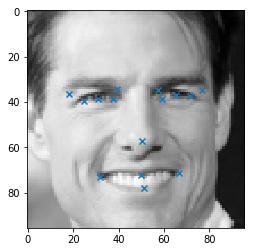

In [88]:
# plot a sample image in gray scale from training dataset
plt.imshow(X_train[1].reshape(96,96), cmap='gray')
plt.scatter(y_train[1, range(0,30,2)], y_train[1, range(1,30,2)], marker='x')

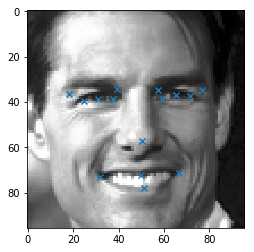

In [89]:
plt.imshow(train2[1].reshape(96,96), cmap='gray')
plt.scatter(y_train[1, range(0,30,2)], y_train[1, range(1,30,2)], marker='x')

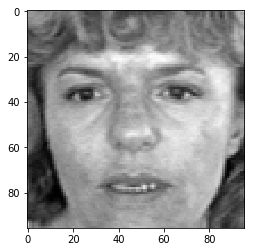

In [22]:
# plot a sample image in gray scale from validation dataset
plt.imshow(X_valid[1].reshape(96,96), cmap='gray')

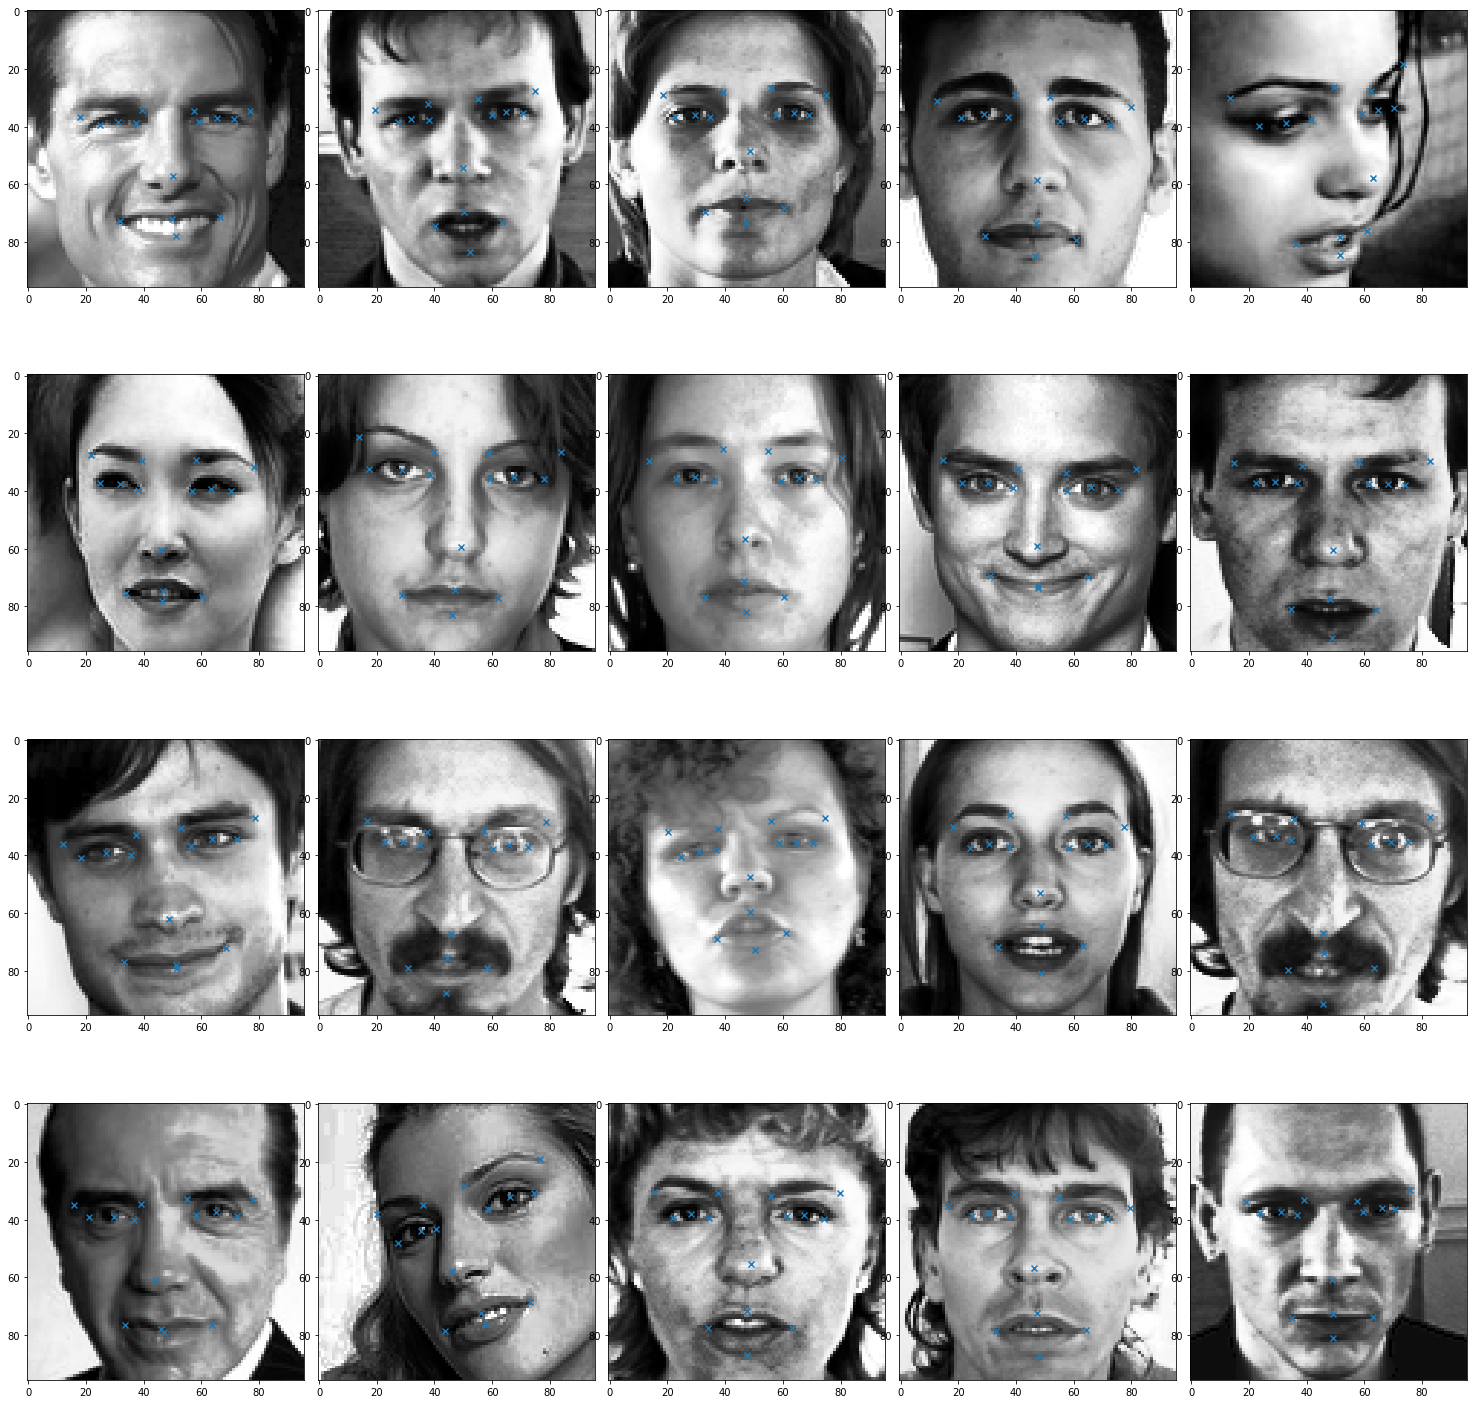

In [24]:
# plot a few sample (augmented) images in gray scale from training dataset with labels
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(1,21):
    plt.subplot(4, 5, i)
    plt.imshow(train2[i, :, :, 0].reshape(96,96), cmap='gray')
    plt.scatter(y_train[i, range(0,30,2)], y_train[i, range(1,30,2)], marker='x')
    
plt.show()

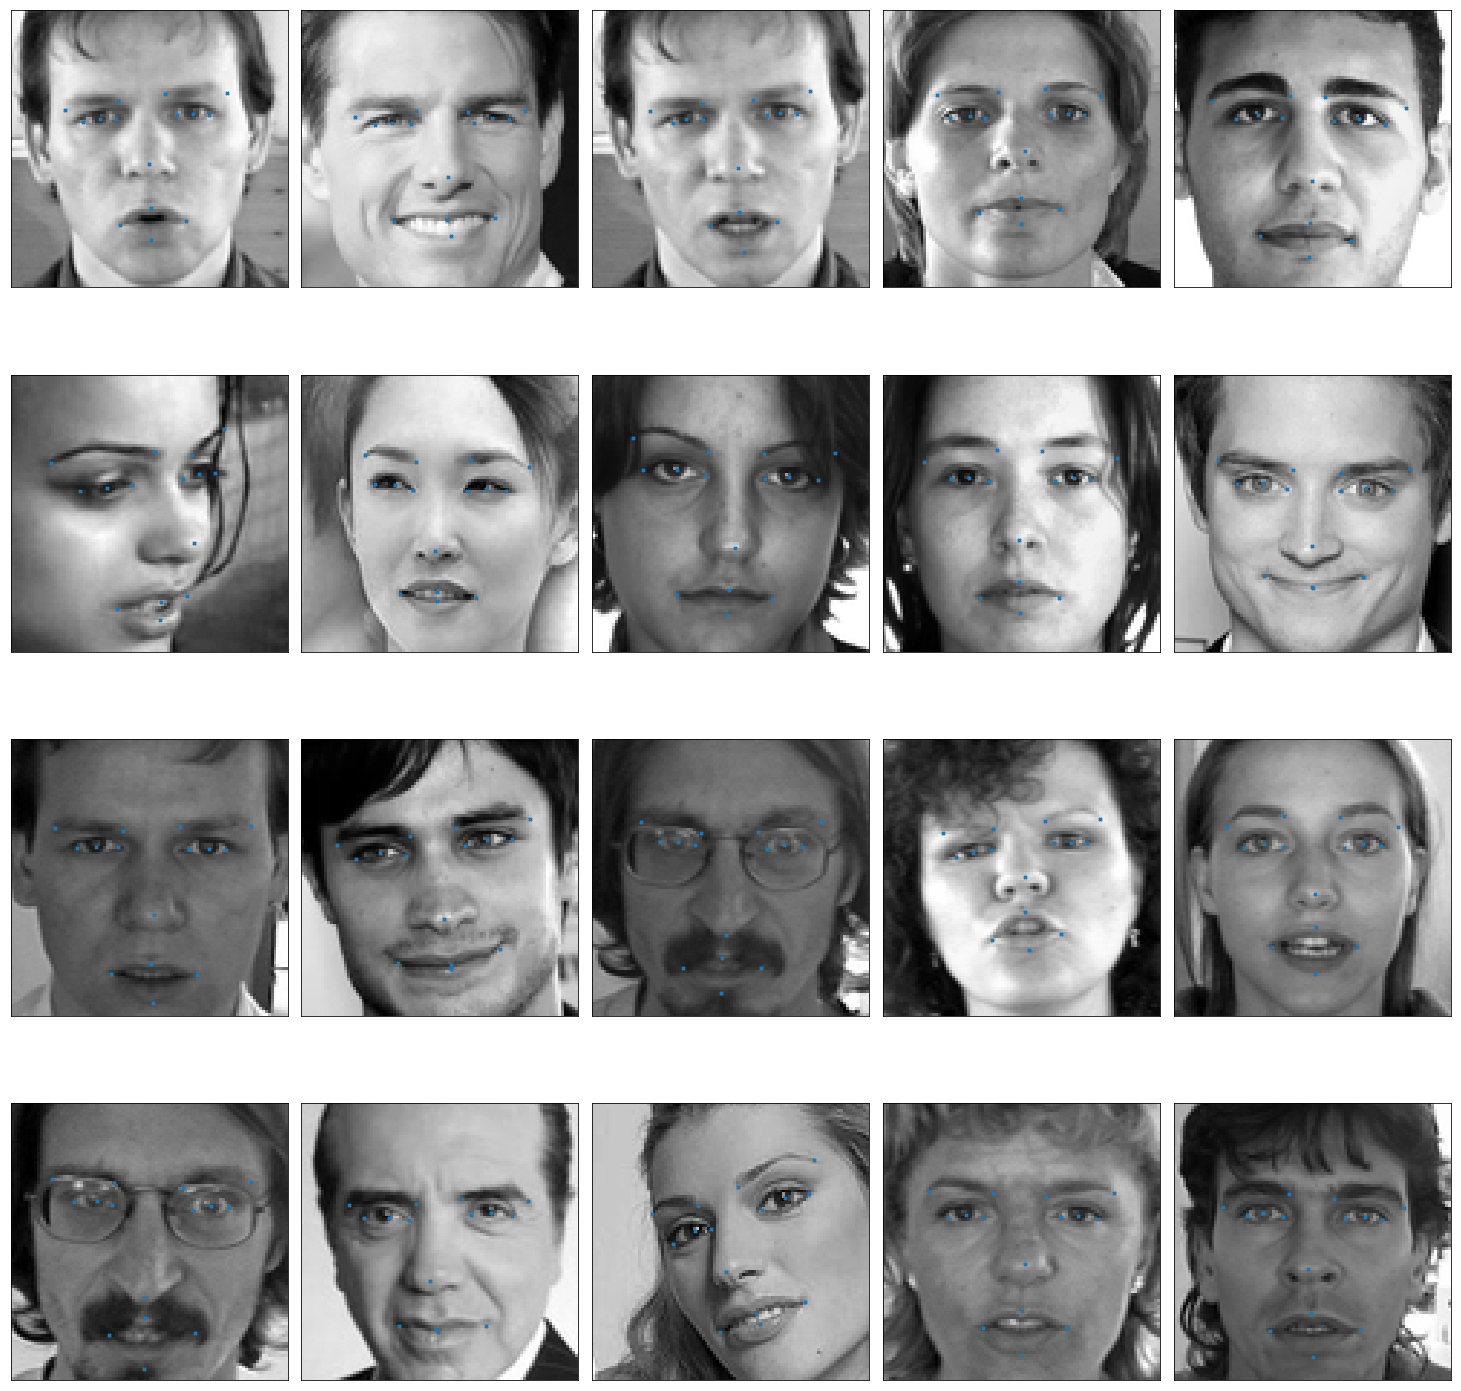

In [25]:
# plot a few sample (un-augmented) images in gray scale from training dataset with labels
def plot_img(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='X', s=10)

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(4,5,i+1, xticks=[], yticks=[])
    plot_img(X_train[i], y_train[i], ax)
    
plt.show()

## Rotation

Define custom function for performing rotation of images to get more training data

In [18]:
from scipy.ndimage import rotate

In [33]:
# function defined by Catherine Cao
# rotate function to transform x
def rotate_X(input_X, degree):
    
    # create an array of the same size
    output_X = np.zeros((input_X.shape), dtype=np.float64)
    
    # for each image, use sklearn's rotate function to rotate image
    # this somehow changes pixel values, cap value between 0 and 255
    for i in range(output_X.shape[0]):
        output_X[i] = np.clip(rotate(input_X[i], degree, reshape=False, mode='constant'), 0, 255)  
#        output_X[i] = np.clip(rotate(input_X.reshape(-1,96,96)[i], degree, reshape=False, mode='constant', \
#                                       cval=150).reshape(96*96), 0, 255)  
    return output_X
        
    
# rotate function to transform y
def rotate_y(input_y, degree, n_point):
    
    # create an array of same size
    output_y = np.zeros((input_y.shape), dtype=np.float64)
    
    # define rotation angle and center of rotation
    theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2

    for i in range(output_y.shape[0]):
        
        # obtain x and y coordinates from dataset
        x = input_y[i][np.arange(0,n_point-1,2)]
        y = input_y[i][np.arange(1,n_point,2)]
        
        # use rotation matrix to rotate coordinates around center
        x2 = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        y2 = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        
        # put x and y back in original shape
        output_y[i] = np.vstack((x2,y2)).transpose().flatten()
        
    return output_y

In [34]:
X_train_rotate = rotate_X(X_train, 10)
y_train_rotate = rotate_y(y_train, 10, 30)

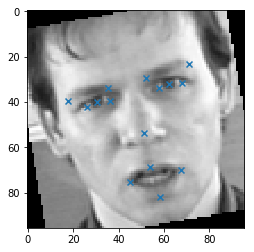

In [37]:
i_val=2
plt.imshow(X_train_rotate[i_val].reshape(96,96), cmap='gray')
plt.scatter(y_train_rotate[i_val, range(0,30,2)], y_train_rotate[i_val, range(1,30,2)], marker='x')


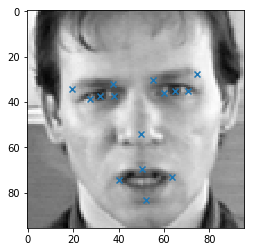

In [38]:
i_val=2
plt.imshow(X_train[i_val].reshape(96,96), cmap='gray')
plt.scatter(y_train[i_val, range(0,30,2)], y_train[i_val, range(1,30,2)], marker='x')


In [51]:
X_train_combined = np.concatenate((X_train, X_train_rotate), axis=0)
y_train_combined = np.concatenate((y_train, y_train_rotate), axis=0)

In [59]:
X_train_combined = np.concatenate((X_train_combined, train2), axis=0)
y_train_combined = np.concatenate((y_train_combined, y_train), axis=0)

In [60]:
X_train.shape

(1712, 96, 96, 1)

In [61]:
X_train_rotate.shape

(1712, 96, 96, 1)

In [62]:
X_train_combined.shape

(5136, 96, 96, 1)

In [63]:
y_train_combined.shape

(5136, 30)

## Set Parameters

Set parameters to iterate and build models for so that it can be displayed on TensorBoard.

In [57]:
import time
from keras import backend as K
from keras.callbacks import TensorBoard
from os import makedirs
from os.path import exists, join

#### Define Metrics

Here, we are dealing with a regression problem, as we are trying to predict coordinate values for facial keypoints.  A good measure to understand how the model performs is the RMSE (Root Mean Squared Error).  We define a function to calculate both rmse and r_square to include in our call to the model.  

Also, we define a folder to capture log of the various runs to display as a TensorBoard.  The directory is created, if it doesn't already exist.


In [58]:
log_dir = './logs'
if not exists(log_dir):
    makedirs(log_dir)
    
    
# define custom metric rmse as this is a regression problem
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# define r_square as custom metric
# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )



## Define Multiple Models (with Dropout)

Here, we are trying to loop through various combinations of the following parameters:

* Number of dense layers (1 or 2)
* Layer sizes for the convolution layer (48 or 64)
* Number of convolution layer (1, 2 or 3)

By building the models to the above combinations, we get to compare among 12 (2 x 2 x 3) different models run for same batch size and 20 epochs.  This is to identify the top 2 best models and run them for 50 epochs to see if we are able to reduce the 'rmse' value further.


## Iterative Model Runs with Tensorboard

The details of each run is logged into a folder so that we can view the same in a TensorBoard.  Each model run is given a unique name based on the parameters that differentiate it, tagged with the time of the run.


In [64]:
# Repeat the above exercise by adding a Dropout Layer
dense_layers=[1,2]
layer_sizes=[48,64]
conv_layers=[2,1]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME="Aug-{}-conv-{}-layer-{}-dense-DO-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)
            tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
            
            model = Sequential()
            model.add(BatchNormalization(input_shape=(96,96,1)))

            # Add convolutional layer with kernel size as 3, 'relu' activation and 'MaxPooling' 
            model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            for cl in range(conv_layer - 1):
                model.add(Conv2D(filters=layer_size, kernel_size=(3,3)) )
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            # Add a layer to flatten before feeding into dense layers
            model.add(Flatten())

            # Add dropout layer to address overfitting issues
            model.add(Dropout(0.3))

            for dl in range(dense_layer):
                # Add dense layer with 100 neurons + 'relu' activation
                model.add(Dense(200))
                model.add(Activation("relu"))

            # Output layer for the 30 labels to be predicted
            model.add(Dense(30))

            # choose 'adam' optimizer and 'mean_squared_error' as loss function; custom metrics for evaluation
            model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae', r_square])
            
            model.fit(X_train_combined, y_train_combined, 
                      epochs=20, batch_size=100, 
                      validation_split=0, validation_data=(X_valid, y_valid), 
                      verbose=2, 
                      callbacks=[tensorboard])

Aug-2-conv-48-layer-1-dense-DO-1544294792
Train on 5136 samples, validate on 428 samples
Epoch 1/20
 - 60s - loss: 355.7074 - rmse: 15.9349 - acc: 0.5130 - mean_absolute_error: 13.1407 - r_square: -3.9177e-03 - val_loss: 151.9376 - val_rmse: 12.3116 - val_acc: 0.6916 - val_mean_absolute_error: 9.9510 - val_r_square: 0.5714
Epoch 2/20
 - 61s - loss: 69.0713 - rmse: 8.2691 - acc: 0.7362 - mean_absolute_error: 6.2736 - r_square: 0.8051 - val_loss: 100.6562 - val_rmse: 10.0239 - val_acc: 0.6916 - val_mean_absolute_error: 8.1382 - val_r_square: 0.7160
Epoch 3/20
 - 60s - loss: 35.4563 - rmse: 5.8668 - acc: 0.7362 - mean_absolute_error: 4.4386 - r_square: 0.9000 - val_loss: 26.4699 - val_rmse: 5.1428 - val_acc: 0.6916 - val_mean_absolute_error: 4.0738 - val_r_square: 0.9253
Epoch 4/20
 - 61s - loss: 12.6932 - rmse: 3.5395 - acc: 0.7366 - mean_absolute_error: 2.6367 - r_square: 0.9642 - val_loss: 9.9102 - val_rmse: 3.1454 - val_acc: 0.6916 - val_mean_absolute_error: 2.3230 - val_r_square: 0.9

Epoch 17/20
 - 52s - loss: 3.0420 - rmse: 1.7412 - acc: 0.8100 - mean_absolute_error: 1.2735 - r_square: 0.9914 - val_loss: 3.9119 - val_rmse: 1.9719 - val_acc: 0.7523 - val_mean_absolute_error: 1.3875 - val_r_square: 0.9890
Epoch 18/20
 - 54s - loss: 2.9833 - rmse: 1.7232 - acc: 0.8080 - mean_absolute_error: 1.2665 - r_square: 0.9916 - val_loss: 3.9495 - val_rmse: 1.9819 - val_acc: 0.7243 - val_mean_absolute_error: 1.4043 - val_r_square: 0.9889
Epoch 19/20
 - 54s - loss: 2.8317 - rmse: 1.6802 - acc: 0.8143 - mean_absolute_error: 1.2300 - r_square: 0.9920 - val_loss: 3.6397 - val_rmse: 1.9018 - val_acc: 0.7500 - val_mean_absolute_error: 1.3240 - val_r_square: 0.9897
Epoch 20/20
 - 54s - loss: 2.7652 - rmse: 1.6603 - acc: 0.8181 - mean_absolute_error: 1.2216 - r_square: 0.9922 - val_loss: 3.6606 - val_rmse: 1.9067 - val_acc: 0.7523 - val_mean_absolute_error: 1.3254 - val_r_square: 0.9897
Aug-2-conv-64-layer-1-dense-DO-1544297096
Train on 5136 samples, validate on 428 samples
Epoch 1/20


Epoch 13/20
 - 51s - loss: 3.7241 - rmse: 1.9258 - acc: 0.7944 - mean_absolute_error: 1.3924 - r_square: 0.9895 - val_loss: 4.2482 - val_rmse: 2.0562 - val_acc: 0.7313 - val_mean_absolute_error: 1.4558 - val_r_square: 0.9880
Epoch 14/20
 - 50s - loss: 3.5195 - rmse: 1.8729 - acc: 0.7928 - mean_absolute_error: 1.3530 - r_square: 0.9901 - val_loss: 4.0303 - val_rmse: 2.0019 - val_acc: 0.7407 - val_mean_absolute_error: 1.4096 - val_r_square: 0.9886
Epoch 15/20
 - 52s - loss: 3.3967 - rmse: 1.8387 - acc: 0.8000 - mean_absolute_error: 1.3326 - r_square: 0.9904 - val_loss: 3.8931 - val_rmse: 1.9675 - val_acc: 0.7336 - val_mean_absolute_error: 1.3840 - val_r_square: 0.9890
Epoch 16/20
 - 51s - loss: 3.2559 - rmse: 1.8011 - acc: 0.8055 - mean_absolute_error: 1.3051 - r_square: 0.9908 - val_loss: 3.9994 - val_rmse: 1.9937 - val_acc: 0.7407 - val_mean_absolute_error: 1.4069 - val_r_square: 0.9887
Epoch 17/20
 - 52s - loss: 3.2083 - rmse: 1.7873 - acc: 0.8069 - mean_absolute_error: 1.3044 - r_squ

Epoch 9/20
 - 56s - loss: 5.4282 - rmse: 2.3252 - acc: 0.7693 - mean_absolute_error: 1.6998 - r_square: 0.9847 - val_loss: 5.8170 - val_rmse: 2.4065 - val_acc: 0.7079 - val_mean_absolute_error: 1.7277 - val_r_square: 0.9836
Epoch 10/20
 - 56s - loss: 5.1784 - rmse: 2.2719 - acc: 0.7747 - mean_absolute_error: 1.6664 - r_square: 0.9854 - val_loss: 6.1082 - val_rmse: 2.4679 - val_acc: 0.7033 - val_mean_absolute_error: 1.7932 - val_r_square: 0.9828
Epoch 11/20
 - 57s - loss: 4.7644 - rmse: 2.1788 - acc: 0.7755 - mean_absolute_error: 1.5947 - r_square: 0.9866 - val_loss: 5.3159 - val_rmse: 2.3014 - val_acc: 0.7173 - val_mean_absolute_error: 1.6537 - val_r_square: 0.9850
Epoch 12/20
 - 55s - loss: 4.3481 - rmse: 2.0832 - acc: 0.7812 - mean_absolute_error: 1.5159 - r_square: 0.9877 - val_loss: 4.9714 - val_rmse: 2.2248 - val_acc: 0.7196 - val_mean_absolute_error: 1.5859 - val_r_square: 0.9860
Epoch 13/20
 - 55s - loss: 4.1687 - rmse: 2.0397 - acc: 0.7870 - mean_absolute_error: 1.4923 - r_squa

Epoch 5/20
 - 52s - loss: 10.9023 - rmse: 3.2890 - acc: 0.7416 - mean_absolute_error: 2.4370 - r_square: 0.9693 - val_loss: 9.5452 - val_rmse: 3.0857 - val_acc: 0.6939 - val_mean_absolute_error: 2.2421 - val_r_square: 0.9731
Epoch 6/20
 - 52s - loss: 8.5346 - rmse: 2.9143 - acc: 0.7477 - mean_absolute_error: 2.1359 - r_square: 0.9759 - val_loss: 7.9971 - val_rmse: 2.8243 - val_acc: 0.6986 - val_mean_absolute_error: 2.0394 - val_r_square: 0.9774
Epoch 7/20
 - 52s - loss: 7.0940 - rmse: 2.6578 - acc: 0.7525 - mean_absolute_error: 1.9401 - r_square: 0.9800 - val_loss: 6.9978 - val_rmse: 2.6410 - val_acc: 0.7009 - val_mean_absolute_error: 1.9004 - val_r_square: 0.9803
Epoch 8/20
 - 53s - loss: 6.4212 - rmse: 2.5292 - acc: 0.7592 - mean_absolute_error: 1.8454 - r_square: 0.9819 - val_loss: 6.3798 - val_rmse: 2.5220 - val_acc: 0.6986 - val_mean_absolute_error: 1.8001 - val_r_square: 0.9820
Epoch 9/20
 - 52s - loss: 5.6246 - rmse: 2.3666 - acc: 0.7671 - mean_absolute_error: 1.7195 - r_square:

### Train Top 2 Models - with 50 Epochs

From the previous run, we see that the following models perform the best:

* 1-conv-64-layer-1-dense-DO (1 convolution layers, filter size=64, 1 dense layer (200 neurons) with Dropout (RMSE:1.71)
* 1-conv-48-layer-1-dense-DO (1 convolution layer, filter size=48, 2 dense layer (200 neurons) with Dropout (RMSE: 1.66)

As this involves 1 or 2 convolution layers as well as 1 or 2 dense layers, we further run another set of models for these combinations of parameter values for 50 epochs.  All other parameters are same as we had in the previous set.


In [30]:
# Repeat the above exercise by adding a Dropout Layer
dense_layers=[1]
layer_sizes=[48, 64]
conv_layers=[1]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME="50epochs-{}-conv-{}-layer-{}-dense-DO-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)
            tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
            
            model = Sequential()
            model.add(BatchNormalization(input_shape=(96,96,1)))

            # Add convolutional layer with kernel size as 3, 'relu' activation and 'MaxPooling' 
            model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            for cl in range(conv_layer - 1):
                model.add(Conv2D(filters=layer_size, kernel_size=(3,3)) )
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            # Add a layer to flatten before feeding into dense layers
            model.add(Flatten())

            # Add dropout layer to address overfitting issues
            model.add(Dropout(0.3))

            for dl in range(dense_layer):
                # Add dense layer with 100 neurons + 'relu' activation
                model.add(Dense(200))
                model.add(Activation("relu"))

            # Output layer for the 30 labels to be predicted
            model.add(Dense(30))

            # choose 'adam' optimizer and 'mean_squared_error' as loss function; custom metrics for evaluation
            model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae', r_square])
            
            model.fit(X_train_combined, y_train_combined, 
                      epochs=50, batch_size=100, 
                      validation_split=0, validation_data=(X_valid, y_valid), 
                      verbose=2, 
                      callbacks=[tensorboard])

50epochs-1-conv-48-layer-1-dense-DO-1543910712
Train on 1712 samples, validate on 428 samples
Epoch 1/50
 - 19s - loss: 689.3097 - rmse: 23.7690 - acc: 0.2891 - mean_absolute_error: 19.5260 - r_square: -9.4981e-01 - val_loss: 222.7549 - val_rmse: 14.9165 - val_acc: 0.6916 - val_mean_absolute_error: 12.2421 - val_r_square: 0.3714
Epoch 2/50
 - 19s - loss: 132.3281 - rmse: 11.3996 - acc: 0.7074 - mean_absolute_error: 8.8827 - r_square: 0.6263 - val_loss: 94.4682 - val_rmse: 9.7168 - val_acc: 0.4907 - val_mean_absolute_error: 7.4205 - val_r_square: 0.7333
Epoch 3/50
 - 19s - loss: 75.1720 - rmse: 8.6209 - acc: 0.5035 - mean_absolute_error: 6.4901 - r_square: 0.7878 - val_loss: 62.7827 - val_rmse: 7.9170 - val_acc: 0.6916 - val_mean_absolute_error: 5.9760 - val_r_square: 0.8227
Epoch 4/50
 - 21s - loss: 52.4531 - rmse: 7.2183 - acc: 0.7155 - mean_absolute_error: 5.3932 - r_square: 0.8522 - val_loss: 46.0271 - val_rmse: 6.7745 - val_acc: 0.6752 - val_mean_absolute_error: 4.9829 - val_r_squa

Epoch 37/50
 - 19s - loss: 3.7512 - rmse: 1.9336 - acc: 0.8189 - mean_absolute_error: 1.4088 - r_square: 0.9894 - val_loss: 6.7495 - val_rmse: 2.5866 - val_acc: 0.7290 - val_mean_absolute_error: 1.7218 - val_r_square: 0.9810
Epoch 38/50
 - 18s - loss: 3.6579 - rmse: 1.9089 - acc: 0.8137 - mean_absolute_error: 1.3911 - r_square: 0.9897 - val_loss: 7.0237 - val_rmse: 2.6431 - val_acc: 0.7547 - val_mean_absolute_error: 1.8783 - val_r_square: 0.9802
Epoch 39/50
 - 20s - loss: 3.5522 - rmse: 1.8818 - acc: 0.8143 - mean_absolute_error: 1.3735 - r_square: 0.9900 - val_loss: 6.5470 - val_rmse: 2.5457 - val_acc: 0.7500 - val_mean_absolute_error: 1.6991 - val_r_square: 0.9815
Epoch 40/50
 - 18s - loss: 3.4864 - rmse: 1.8538 - acc: 0.8166 - mean_absolute_error: 1.3642 - r_square: 0.9902 - val_loss: 6.5272 - val_rmse: 2.5458 - val_acc: 0.7266 - val_mean_absolute_error: 1.7665 - val_r_square: 0.9816
Epoch 41/50
 - 19s - loss: 3.2295 - rmse: 1.7952 - acc: 0.8072 - mean_absolute_error: 1.3075 - r_squ

Epoch 23/50
 - 22s - loss: 6.7360 - rmse: 2.5861 - acc: 0.7231 - mean_absolute_error: 1.8818 - r_square: 0.9810 - val_loss: 6.0334 - val_rmse: 2.4520 - val_acc: 0.7056 - val_mean_absolute_error: 1.7397 - val_r_square: 0.9830
Epoch 24/50
 - 22s - loss: 6.2031 - rmse: 2.4812 - acc: 0.7202 - mean_absolute_error: 1.7843 - r_square: 0.9825 - val_loss: 7.1051 - val_rmse: 2.6615 - val_acc: 0.7009 - val_mean_absolute_error: 1.9588 - val_r_square: 0.9800
Epoch 25/50
 - 24s - loss: 6.3596 - rmse: 2.5175 - acc: 0.7220 - mean_absolute_error: 1.8295 - r_square: 0.9821 - val_loss: 8.3789 - val_rmse: 2.8918 - val_acc: 0.7056 - val_mean_absolute_error: 2.1556 - val_r_square: 0.9764
Epoch 26/50
 - 21s - loss: 6.1956 - rmse: 2.4785 - acc: 0.7225 - mean_absolute_error: 1.8052 - r_square: 0.9825 - val_loss: 5.5368 - val_rmse: 2.3489 - val_acc: 0.6963 - val_mean_absolute_error: 1.6666 - val_r_square: 0.9844
Epoch 27/50
 - 23s - loss: 5.7386 - rmse: 2.3899 - acc: 0.7301 - mean_absolute_error: 1.7227 - r_squ

Epoch 9/50
 - 20s - loss: 18.1296 - rmse: 4.2423 - acc: 0.7097 - mean_absolute_error: 3.0831 - r_square: 0.9489 - val_loss: 27.4130 - val_rmse: 5.2089 - val_acc: 0.6893 - val_mean_absolute_error: 3.7014 - val_r_square: 0.9227
Epoch 10/50
 - 18s - loss: 18.8721 - rmse: 4.3265 - acc: 0.7103 - mean_absolute_error: 3.1841 - r_square: 0.9467 - val_loss: 19.4548 - val_rmse: 4.3881 - val_acc: 0.7033 - val_mean_absolute_error: 3.0387 - val_r_square: 0.9451
Epoch 11/50
 - 20s - loss: 15.4486 - rmse: 3.9209 - acc: 0.7185 - mean_absolute_error: 2.8460 - r_square: 0.9564 - val_loss: 16.6509 - val_rmse: 4.0582 - val_acc: 0.7033 - val_mean_absolute_error: 2.8380 - val_r_square: 0.9530
Epoch 12/50
 - 18s - loss: 14.2490 - rmse: 3.7660 - acc: 0.7138 - mean_absolute_error: 2.7508 - r_square: 0.9598 - val_loss: 17.0606 - val_rmse: 4.1226 - val_acc: 0.7009 - val_mean_absolute_error: 2.9808 - val_r_square: 0.9518
Epoch 13/50
 - 19s - loss: 13.9599 - rmse: 3.7223 - acc: 0.7231 - mean_absolute_error: 2.7394

Epoch 46/50
 - 19s - loss: 4.0939 - rmse: 2.0110 - acc: 0.7862 - mean_absolute_error: 1.5004 - r_square: 0.9884 - val_loss: 6.0548 - val_rmse: 2.4494 - val_acc: 0.7220 - val_mean_absolute_error: 1.6809 - val_r_square: 0.9829
Epoch 47/50
 - 18s - loss: 4.2140 - rmse: 2.0402 - acc: 0.7856 - mean_absolute_error: 1.5193 - r_square: 0.9881 - val_loss: 5.8891 - val_rmse: 2.4150 - val_acc: 0.7103 - val_mean_absolute_error: 1.6090 - val_r_square: 0.9834
Epoch 48/50
 - 19s - loss: 3.8108 - rmse: 1.9463 - acc: 0.7868 - mean_absolute_error: 1.4324 - r_square: 0.9893 - val_loss: 5.9571 - val_rmse: 2.4280 - val_acc: 0.7407 - val_mean_absolute_error: 1.6243 - val_r_square: 0.9832
Epoch 49/50
 - 19s - loss: 3.7412 - rmse: 1.9276 - acc: 0.7897 - mean_absolute_error: 1.4305 - r_square: 0.9894 - val_loss: 6.5568 - val_rmse: 2.5530 - val_acc: 0.7336 - val_mean_absolute_error: 1.8092 - val_r_square: 0.9815
Epoch 50/50
 - 18s - loss: 4.3971 - rmse: 2.0805 - acc: 0.7956 - mean_absolute_error: 1.5715 - r_squ

Epoch 32/50
 - 22s - loss: 6.0791 - rmse: 2.4589 - acc: 0.7261 - mean_absolute_error: 1.7884 - r_square: 0.9829 - val_loss: 6.2418 - val_rmse: 2.4949 - val_acc: 0.6916 - val_mean_absolute_error: 1.7624 - val_r_square: 0.9824
Epoch 33/50
 - 22s - loss: 6.1972 - rmse: 2.4784 - acc: 0.7225 - mean_absolute_error: 1.8036 - r_square: 0.9825 - val_loss: 6.0859 - val_rmse: 2.4632 - val_acc: 0.6939 - val_mean_absolute_error: 1.7438 - val_r_square: 0.9828
Epoch 34/50
 - 22s - loss: 5.9506 - rmse: 2.4352 - acc: 0.7261 - mean_absolute_error: 1.7718 - r_square: 0.9832 - val_loss: 5.8351 - val_rmse: 2.4119 - val_acc: 0.6939 - val_mean_absolute_error: 1.6978 - val_r_square: 0.9835
Epoch 35/50
 - 22s - loss: 6.0061 - rmse: 2.4437 - acc: 0.7307 - mean_absolute_error: 1.7796 - r_square: 0.9831 - val_loss: 8.3859 - val_rmse: 2.8920 - val_acc: 0.6963 - val_mean_absolute_error: 2.1491 - val_r_square: 0.9763
Epoch 36/50
 - 22s - loss: 6.4215 - rmse: 2.5272 - acc: 0.7278 - mean_absolute_error: 1.8729 - r_squ

## Rockstar-Net (Convolutional Neural Network)

Of the runs from above, we see that the 'Rockstar' neural network is:

* 1 additional Convolution Layer (layer size=48), in addition to the basic one with size=32
* 1 Dense Layer with 200 neurons
* Dropout Rate of 30%

This gives an RMSE of 1.614 in 50 epochs.


In [74]:
# Run Rockstart Network to save the model (1-ConvLayer-48-layersize-1-DenseLayer-WithDropOut)

# Repeat the above exercise by adding a Dropout Layer
dense_layers=[1]
layer_sizes=[48]
conv_layers=[1]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME="Aug-{}-conv-{}-layer-{}-dense-DO-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)
            tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
            
            model = Sequential()
            model.add(BatchNormalization(input_shape=(96,96,1)))

            # Add convolutional layer with kernel size as 3, 'relu' activation and 'MaxPooling' 
            model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            for cl in range(conv_layer - 1):
                model.add(Conv2D(filters=layer_size, kernel_size=(3,3)) )
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            # Add a layer to flatten before feeding into dense layers
            model.add(Flatten())

            # Add dropout layer to address overfitting issues
            model.add(Dropout(0.3))

            for dl in range(dense_layer):
                # Add dense layer with 100 neurons + 'relu' activation
                model.add(Dense(200))
                model.add(Activation("relu"))

            # Output layer for the 30 labels to be predicted
            model.add(Dense(30))

            # choose 'adam' optimizer and 'mean_squared_error' as loss function; custom metrics for evaluation
            model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae', r_square])
            
            model.fit(X_train_combined, y_train_combined, 
                      epochs=50, batch_size=100, 
                      validation_split=0, validation_data=(X_valid, y_valid), 
                      verbose=2, 
                      callbacks=[tensorboard])

Aug-1-conv-48-layer-1-dense-DO-1544306098
Train on 5136 samples, validate on 428 samples
Epoch 1/50
 - 54s - loss: 249.4580 - rmse: 13.8923 - acc: 0.4204 - mean_absolute_error: 11.0395 - r_square: 0.2945 - val_loss: 163.0908 - val_rmse: 12.7585 - val_acc: 0.6752 - val_mean_absolute_error: 10.3890 - val_r_square: 0.5398
Epoch 2/50
 - 53s - loss: 64.6797 - rmse: 7.9899 - acc: 0.7371 - mean_absolute_error: 5.9845 - r_square: 0.8176 - val_loss: 94.5761 - val_rmse: 9.7145 - val_acc: 0.7079 - val_mean_absolute_error: 7.9465 - val_r_square: 0.7331
Epoch 3/50
 - 52s - loss: 31.9427 - rmse: 5.6101 - acc: 0.7430 - mean_absolute_error: 4.2293 - r_square: 0.9099 - val_loss: 25.8912 - val_rmse: 5.0838 - val_acc: 0.6939 - val_mean_absolute_error: 3.9923 - val_r_square: 0.9269
Epoch 4/50
 - 53s - loss: 15.6554 - rmse: 3.9379 - acc: 0.7502 - mean_absolute_error: 2.9639 - r_square: 0.9558 - val_loss: 16.2033 - val_rmse: 4.0215 - val_acc: 0.6963 - val_mean_absolute_error: 3.1531 - val_r_square: 0.9543
E

Epoch 37/50
 - 53s - loss: 1.9773 - rmse: 1.4043 - acc: 0.8444 - mean_absolute_error: 1.0414 - r_square: 0.9944 - val_loss: 3.4018 - val_rmse: 1.8371 - val_acc: 0.7570 - val_mean_absolute_error: 1.2921 - val_r_square: 0.9904
Epoch 38/50
 - 53s - loss: 2.0351 - rmse: 1.4246 - acc: 0.8456 - mean_absolute_error: 1.0629 - r_square: 0.9943 - val_loss: 3.4317 - val_rmse: 1.8465 - val_acc: 0.7547 - val_mean_absolute_error: 1.2886 - val_r_square: 0.9903
Epoch 39/50
 - 52s - loss: 1.9439 - rmse: 1.3924 - acc: 0.8491 - mean_absolute_error: 1.0384 - r_square: 0.9945 - val_loss: 3.3138 - val_rmse: 1.8127 - val_acc: 0.7547 - val_mean_absolute_error: 1.2622 - val_r_square: 0.9907
Epoch 40/50
 - 52s - loss: 2.0360 - rmse: 1.4242 - acc: 0.8481 - mean_absolute_error: 1.0682 - r_square: 0.9942 - val_loss: 3.3459 - val_rmse: 1.8219 - val_acc: 0.7430 - val_mean_absolute_error: 1.2867 - val_r_square: 0.9906
Epoch 41/50
 - 52s - loss: 1.9937 - rmse: 1.4105 - acc: 0.8438 - mean_absolute_error: 1.0574 - r_squ

### Save Model 

The resulting model (Rockstar Model) is saved so that we can load and validate against any dataset at a later time.


In [75]:
model.save('Sudha-FKP4-WithRotation_HistEq-2.h5')

## Run for 100 Epochs

In [36]:
# Run Rockstart Network to save the model (1-ConvLayer-48-layersize-1-DenseLayer-WithDropOut)

dense_layers=[1]
layer_sizes=[48]
conv_layers=[1]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME="Aug-{}-conv-{}-layer-{}-dense-DO-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)
            tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
            
            model = Sequential()
            model.add(BatchNormalization(input_shape=(96,96,1)))

            # Add convolutional layer with kernel size as 3, 'relu' activation and 'MaxPooling' 
            model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(96,96,1), padding="same"))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            for cl in range(conv_layer - 1):
                model.add(Conv2D(filters=layer_size, kernel_size=(3,3)) )
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

            # Add a layer to flatten before feeding into dense layers
            model.add(Flatten())

            # Add dropout layer to address overfitting issues
            model.add(Dropout(0.3))

            for dl in range(dense_layer):
                # Add dense layer with 100 neurons + 'relu' activation
                model.add(Dense(200))
                model.add(Activation("relu"))

            # Output layer for the 30 labels to be predicted
            model.add(Dense(30))

            # choose 'adam' optimizer and 'mean_squared_error' as loss function; custom metrics for evaluation
            model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse, 'accuracy', 'mae', r_square])
            
            model.fit(X_train_combined, y_train_combined, 
                      epochs=100, batch_size=100, 
                      validation_split=0, validation_data=(X_valid, y_valid), 
                      verbose=2, 
                      callbacks=[tensorboard])

100epochs-2-conv-64-layer-1-dense-DO-1543970995
Train on 1712 samples, validate on 428 samples
Epoch 1/100
 - 25s - loss: 736.4864 - rmse: 24.2339 - acc: 0.2477 - mean_absolute_error: 20.6436 - r_square: -1.0658e+00 - val_loss: 175.5775 - val_rmse: 13.2383 - val_acc: 0.2593 - val_mean_absolute_error: 10.0904 - val_r_square: 0.5044
Epoch 2/100
 - 24s - loss: 134.5460 - rmse: 11.5396 - acc: 0.5345 - mean_absolute_error: 8.8326 - r_square: 0.6201 - val_loss: 96.4925 - val_rmse: 9.8200 - val_acc: 0.6916 - val_mean_absolute_error: 7.2956 - val_r_square: 0.7276
Epoch 3/100
 - 25s - loss: 77.1510 - rmse: 8.7590 - acc: 0.7039 - mean_absolute_error: 6.6243 - r_square: 0.7823 - val_loss: 66.1888 - val_rmse: 8.1287 - val_acc: 0.6916 - val_mean_absolute_error: 6.1500 - val_r_square: 0.8132
Epoch 4/100
 - 24s - loss: 54.0908 - rmse: 7.3400 - acc: 0.7085 - mean_absolute_error: 5.5002 - r_square: 0.8474 - val_loss: 48.8988 - val_rmse: 6.9861 - val_acc: 0.6916 - val_mean_absolute_error: 5.1170 - val_r

Epoch 37/100
 - 25s - loss: 3.1798 - rmse: 1.7810 - acc: 0.7798 - mean_absolute_error: 1.2873 - r_square: 0.9910 - val_loss: 3.7373 - val_rmse: 1.9271 - val_acc: 0.7266 - val_mean_absolute_error: 1.3331 - val_r_square: 0.9895
Epoch 38/100
 - 28s - loss: 3.1497 - rmse: 1.7721 - acc: 0.7926 - mean_absolute_error: 1.2931 - r_square: 0.9911 - val_loss: 3.6889 - val_rmse: 1.9149 - val_acc: 0.7243 - val_mean_absolute_error: 1.3222 - val_r_square: 0.9896
Epoch 39/100
 - 26s - loss: 3.2465 - rmse: 1.7967 - acc: 0.7845 - mean_absolute_error: 1.3218 - r_square: 0.9908 - val_loss: 5.9211 - val_rmse: 2.4287 - val_acc: 0.7266 - val_mean_absolute_error: 1.8361 - val_r_square: 0.9833
Epoch 40/100
 - 24s - loss: 3.8181 - rmse: 1.9421 - acc: 0.7880 - mean_absolute_error: 1.4437 - r_square: 0.9892 - val_loss: 5.2370 - val_rmse: 2.2850 - val_acc: 0.7336 - val_mean_absolute_error: 1.6929 - val_r_square: 0.9852
Epoch 41/100
 - 25s - loss: 3.7892 - rmse: 1.9402 - acc: 0.7915 - mean_absolute_error: 1.4567 - 

Epoch 74/100
 - 25s - loss: 2.2646 - rmse: 1.4999 - acc: 0.8341 - mean_absolute_error: 1.1359 - r_square: 0.9936 - val_loss: 2.9236 - val_rmse: 1.7050 - val_acc: 0.7383 - val_mean_absolute_error: 1.1508 - val_r_square: 0.9918
Epoch 75/100
 - 25s - loss: 1.8697 - rmse: 1.3659 - acc: 0.8324 - mean_absolute_error: 1.0192 - r_square: 0.9947 - val_loss: 2.9959 - val_rmse: 1.7263 - val_acc: 0.7430 - val_mean_absolute_error: 1.1717 - val_r_square: 0.9916
Epoch 76/100
 - 25s - loss: 2.0355 - rmse: 1.4222 - acc: 0.8388 - mean_absolute_error: 1.0669 - r_square: 0.9943 - val_loss: 3.8052 - val_rmse: 1.9463 - val_acc: 0.7383 - val_mean_absolute_error: 1.3972 - val_r_square: 0.9893
Epoch 77/100
 - 26s - loss: 1.9681 - rmse: 1.3995 - acc: 0.8382 - mean_absolute_error: 1.0483 - r_square: 0.9944 - val_loss: 2.9531 - val_rmse: 1.7134 - val_acc: 0.7453 - val_mean_absolute_error: 1.1637 - val_r_square: 0.9917
Epoch 78/100
 - 26s - loss: 1.7764 - rmse: 1.3311 - acc: 0.8329 - mean_absolute_error: 0.9923 - 

In [37]:
model.save('Sudha-FKP-WithAugmentation-100Epochs.h5')

### Prediction Time

Let's try to use the model built and print facial keypoints for a few examples.  For this, we capture the predictions and do a scatter plot of the points on the image.  After validating this on one image sample, we run it for a group of images and plot the labels on each of the images.


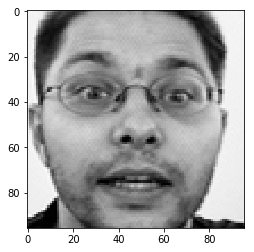

In [25]:
plt.imshow(X_test[0].reshape(96,96), cmap='gray')

In [76]:
# predicting labels for one example test image
predictions = model.predict(X_test[0].reshape(-1,96,96,1))

In [77]:
predictions

array([[65.80166 , 37.820778, 29.777523, 37.107178, 60.995632, 38.53076 ,
        72.38658 , 38.72328 , 35.87918 , 37.88608 , 23.526506, 37.264336,
        57.39858 , 27.138956, 79.04247 , 28.486334, 38.960754, 26.551424,
        17.408669, 26.144104, 49.483444, 52.59077 , 62.89034 , 75.87916 ,
        32.653492, 75.62205 , 48.61633 , 69.70981 , 48.523922, 84.95311 ]],
      dtype=float32)

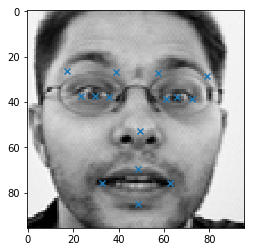

In [78]:
plt.imshow(X_test[0, :, :, 0].reshape(96,96), cmap='gray')
plt.scatter(predictions.reshape(30,)[range(0,30,2)], predictions.reshape(30,)[range(1,30,2)], marker='x')


In [82]:
y_test = model.predict(X_test)

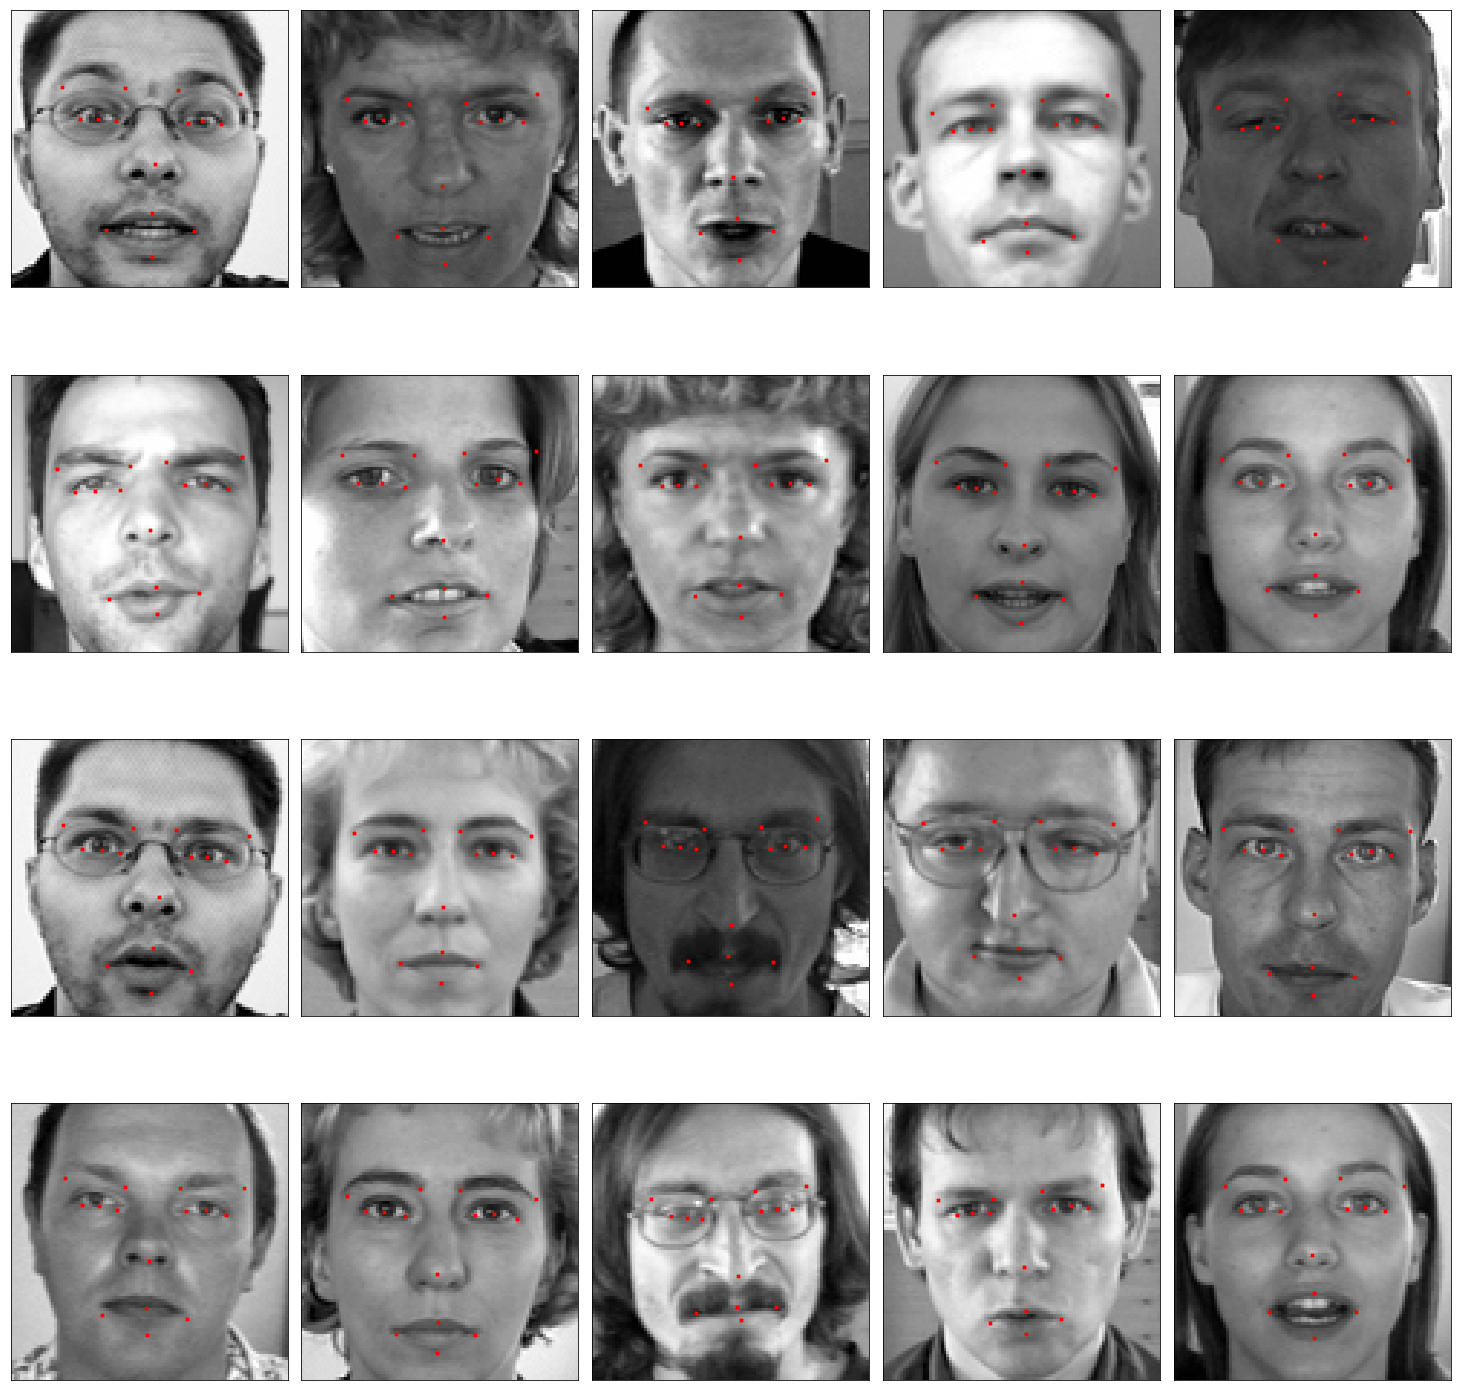

In [80]:
def plot_img(x, y, axis):
    img = x.reshape(96,96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='X', s=10, color='red')

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(4,5,i+1, xticks=[], yticks=[])
    plot_img(X_test[i], y_test[i], ax)
    
plt.show()

In [81]:
score_model11 = model.evaluate(X_valid, y_valid, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score_model11[1]))

rmse: 1.77%


In [83]:
import pandas as pd

In [84]:
fkp_id = pd.read_csv('IdLookupTable.csv')
fkp_id.drop('Location', axis=1, inplace=True)
td = pd.read_csv('./training/training.csv')
ind = np.array(td.columns[:-1])
value=np.array(range(0,30))
maps = pd.Series(value, ind)
fkp_id['location_id'] = fkp_id.FeatureName.map(maps)
df = fkp_id.copy()

location = pd.DataFrame({'Location':[]})
for i in range(1, 1784):
    ind = df[df.ImageId==i].location_id
    location = location.append(pd.DataFrame(y_test[i-1][list(ind)], columns=['Location']), ignore_index=True)
    
fkp_id['Location'] = location

fkp_id[['RowId', 'Location']].to_csv('Submission2.csv', index=False)


In [37]:
tb_snapshot = cv2.imread('TensorBoard-Snapshot-20181203.png')

Below is a snapshot of the TensorBoard for the Rockstar Model Run


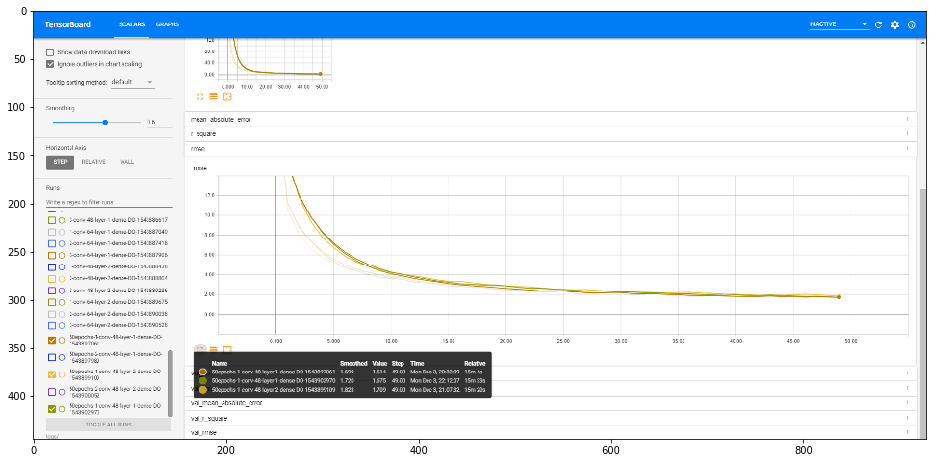

In [38]:
print("Below is a snapshot of the TensorBoard for the Rockstar Model Run")
plt.figure(figsize=(16,16))
plt.imshow(tb_snapshot)